# Testing Stable Baselines3 with gym-MiniGrid

## Basic Jupyter Setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Import Stable-Baselines3 and initial set-up

Import libraries and classes:

In [2]:
# Imports
import time
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from random import randint 
from stable_baselines3 import PPO, DQN, A2C
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env

import gym
from gym import spaces
from gym.wrappers import Monitor
import gym_minigrid
from gym_minigrid.wrappers import FlatObsWrapper, ImgObsWrapper, RGBImgPartialObsWrapper

Define wrapper for CNN Policy

In [3]:
def ImgRGBImgPartialObsWrapper(env):
    return ImgObsWrapper(RGBImgPartialObsWrapper(env))

Define the video function:

In [4]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


Define the rendering wrappers:

In [5]:
from gym.wrappers import Monitor

# Monitor is a gym wrapper, which helps easy rendering of videos of the wrapped environment.
def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    return wrap_env(FlatObsWrapper(gym.make(env_name)))

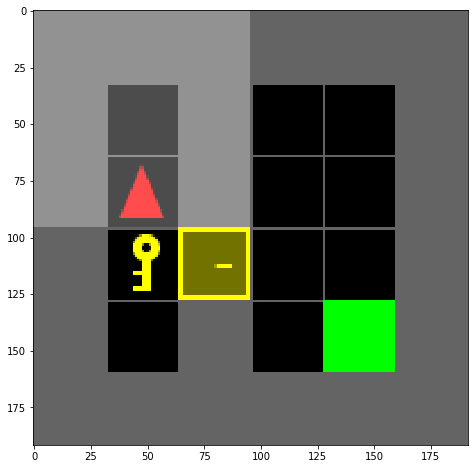

In [6]:
from random import randint
#env_id = 'MiniGrid-Empty-16x16-v0'
env_id = 'MiniGrid-DoorKey-6x6-v0'
#env_id = 'MiniGrid-DistShift1-v0'
#env_id ='MiniGrid-UnlockPickup-v0'
#env_id = 'MiniGrid-RedBlueDoors-6x6-v0'
#env_id = 'MiniGrid-LavaGapS6-v0'

eval_env = gym.make(env_id)
eval_env.seed(10000+randint(0, 10))
eval_env.reset()
before_img = eval_env.render('rgb_array')

plt.imshow(before_img);

# Catastrophic Forgetting

## Define the environments

In [ ]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use

env_id_1 = 'MiniGrid-DoorKey-6x6-v0'
vec_env_1 = make_vec_env(env_id_1, n_envs=num_cpu, wrapper_class=FlatObsWrapper, seed=10000)

env_id_2 = 'MiniGrid-LavaGapS6-v0'
vec_env_2 = make_vec_env(env_id_2, n_envs=num_cpu, wrapper_class=FlatObsWrapper, seed=5000)

env_id_3 = 'MiniGrid-RedBlueDoors-6x6-v0'
vec_env_3 = make_vec_env(env_id_3, n_envs=num_cpu, wrapper_class=FlatObsWrapper, seed=20000)

In [ ]:
from stable_baselines3.common.utils import get_device
get_device()

In [ ]:
learning_rate = 0.00005
n_steps = 256
batch_size = 16
ent_coef = 0.001
n_epochs = 4

tensorboard_log = "./tmp/log/"
os.makedirs(tensorboard_log, exist_ok=True)

## Learn first environment:

In [ ]:
# Reset the environment
vec_env_1.reset()

# create the model
model = PPO('MlpPolicy',
            env=vec_env_1,
            learning_rate=learning_rate,
            batch_size=batch_size,
            ent_coef=ent_coef,
            n_epochs=n_epochs,
            n_steps=n_steps,
            tensorboard_log=tensorboard_log,
            verbose=1)

In [ ]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
tb_log_name = 'task01-doorkey-6x6'

# Create eval environment
env = gym.make(env_id_1)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();

# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.92, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

In [ ]:
total_timesteps = 1000000
log_interval = 10

model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name,
            callback=eval_callback)

In [ ]:
print(tb_log_name)

In [ ]:
# Save the agent
model.save(tb_log_name)

In [ ]:
#model = PPO.load(path=tb_log_name)

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_1))

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

In [ ]:
env_id = env_id_1
test_env = gen_wrapped_env(env_id)
# generate a random initialization for the environment

test_env.seed(randint(1, num_cpu))
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

## Learn second environment

In [ ]:
#model = PPO.load(path=tb_log_name)

In [ ]:
model.set_env(vec_env_2)

In [ ]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
tb_log_name = 'task02-lava'

# Create eval environment
env = gym.make(env_id_2)
env = FlatObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();

# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.92, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

In [ ]:
# number of timesteps to add
total_timesteps = 5000000
log_interval = 10

# resume training using same tensorboard run without resetting the timesteps
model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name=tb_log_name,
            reset_num_timesteps=True,
            callback=eval_callback)

In [ ]:
print(tb_log_name)

In [ ]:
# Save the agent
model.save(tb_log_name)

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_2))
eval_env.seed(10000+randint(0, 10))
eval_env.reset()
# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

In [ ]:
test_env = gen_wrapped_env(env_id_2)
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

In [ ]:
# We create a separate environment for evaluation
eval_env = FlatObsWrapper(gym.make(env_id_1))
eval_env.seed(10000+randint(0, 10))
eval_env.reset()
# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)
print(f'Mean reward: {mean_reward} +/- {std_reward:.2f}')

In [ ]:
test_env = gen_wrapped_env(env_id_1)
test_env.seed(10000+randint(0, 10))
observation = test_env.reset()

done = False
episode_reward = 0
episode_length = 0

while not done:
  #test_env.render()
  action, states = model.predict(observation, deterministic=False)
  observation, reward, done, info = test_env.step(action)
  episode_reward += reward
  episode_length += 1

print('Total reward:', episode_reward)
print('Total length:', episode_length)

test_env.close()
show_video()

# Test training with CNN Policy

## Define the environments

In [7]:
# By default, we use a DummyVecEnv as it is usually faster (cf doc)
num_cpu = 16  # Number of processes to use

env_id_1 = 'MiniGrid-DoorKey-6x6-v0'
vec_env_1 = make_vec_env(env_id_1, n_envs=num_cpu, wrapper_class=ImgRGBImgPartialObsWrapper, seed=10000)

env_id_2 = 'MiniGrid-LavaGapS6-v0'
vec_env_2 = make_vec_env(env_id_2, n_envs=num_cpu, wrapper_class=ImgRGBImgPartialObsWrapper, seed=5000)

Test which device is in use:

In [8]:
from stable_baselines3.common.utils import get_device
get_device()

device(type='cuda')

Test wrapper output shape:

In [9]:
obs = vec_env_1.reset()
print('Observation:', obs, ', Observation Shape: ', obs.shape)

Observation: [[[[55 55 55]
   [33 33 33]
   [33 33 33]
   ...
   [33 33 33]
   [33 33 33]
   [33 33 33]]

  [[33 33 33]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  [[33 33 33]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  ...

  [[99 99 99]
   [76 76 76]
   [76 76 76]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  [[99 99 99]
   [76 76 76]
   [76 76 76]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  [[99 99 99]
   [76 76 76]
   [76 76 76]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]]


 [[[55 55 55]
   [33 33 33]
   [33 33 33]
   ...
   [33 33 33]
   [33 33 33]
   [33 33 33]]

  [[33 33 33]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  [[33 33 33]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  ...

  [[33 33 33]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  [[33 33 33]
   [ 0  0  0]
   [ 0  0  0]

In [10]:
learning_rate = 0.00005
n_steps = 256
batch_size = 16
ent_coef = 0.001
n_epochs = 4

tensorboard_log = "./tmp/log/"
os.makedirs(tensorboard_log, exist_ok=True)

## Learn first environment with CnnPolicy

In [11]:
# Reset the environment
vec_env_1.reset()

# create the model
model = PPO('CnnPolicy',
            env=vec_env_1,
            learning_rate=learning_rate,
            batch_size=batch_size,
            ent_coef=ent_coef,
            n_epochs=n_epochs,
            n_steps=n_steps,
            tensorboard_log=tensorboard_log,
            verbose=1)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [12]:
log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)
tb_log_name = 'task01-doorkey-6x6_cnn'

# Create eval environment
env = gym.make(env_id_1)
env = ImgRGBImgPartialObsWrapper(env)
eval_env = stable_baselines3.common.monitor.Monitor(env, log_dir)
# Reset the environment
eval_env.reset();

# Stop training when the model reaches the reward threshold
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=0.92, verbose=1)
eval_callback = EvalCallback(eval_env, log_path=log_dir, callback_on_new_best=callback_on_best, verbose=1)

In [ ]:
total_timesteps = 1000000
log_interval = 10

model.learn(total_timesteps=total_timesteps,
            log_interval=log_interval,
            tb_log_name = tb_log_name,
            callback=eval_callback)

In [26]:
# Save the agent
model.save(tb_log_name)